In [1]:
print("ok all")

ok all


In [2]:
import os,sys
projject_root = os.path.abspath(os.path.join(os.getcwd(),".."))
sys.path.append(projject_root)

print(projject_root)

d:\Sunny_savitha\auto_rec\automated-research-report-generation


In [3]:
from research_and_analysts.utils.model_loader import ModelLoader


In [4]:
model_loader = ModelLoader()

{"timestamp": "2025-10-27T04:03:48.546978Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-10-27T04:03:48.546978Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-10-27T04:03:48.546978Z", "level": "warning", "event": "ASTRA_DB_API_ENDPOINT is missing from environment"}
{"timestamp": "2025-10-27T04:03:48.546978Z", "level": "warning", "event": "ASTRA_DB_APPLICATION_TOKEN is missing from environment"}
{"timestamp": "2025-10-27T04:03:48.556048Z", "level": "warning", "event": "ASTRA_DB_KEYSPACE is missing from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-10-27T04:03:48.576831Z", "level": "info", "event": "YAML config loaded"}


In [5]:
llm = model_loader.load_llm()

{"provider": "google", "model": "gemini-2.0-flash", "timestamp": "2025-10-27T04:03:48.594427Z", "level": "info", "event": "Loading LLM"}


In [6]:
llm.invoke("Hi").content

'Hi there! How can I help you today?'

In [7]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [8]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from IPython.display import Image, display

In [9]:
class Analyst(BaseModel):
    name:str = Field(description="Name of analyst.")
    role:str = Field(description="Role of analyst in context of topic")
    affiliation:str = Field(description="Primary affiliation of the analyst")
    description:str = Field(description="Description of the analyst focus, concerns and motives.")

    @property
    def persona(self)->str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    

In [10]:
analyst = Analyst(
    name="Munavar",
    role="gen_ai eng",
    affiliation="AI Research Lab",
    description="I am genai eng"
)

In [11]:
analyst.name

'Munavar'

In [12]:
print(analyst.persona)

Name: Munavar
Role: gen_ai eng
Affiliation: AI Research Lab
Description: I am genai eng



In [13]:
class Perspective(BaseModel):
    analysts: List[Analyst] = Field(description="Comprehensive list of analyst with theor roles and affiliations.")

In [14]:
class GenerativeAnalystState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback:str
    analysts: List[Analyst]

In [15]:
GenerativeAnalystState(
    topic= "finance",
    max_analysts= 5,
    human_analyst_feedback="Give the real info"
)

{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'Give the real info'}

In [16]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [17]:
def create_analyst(state:GenerativeAnalystState):
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")

    structured_llm = llm.with_structured_output(Perspective)
    system_message = analyst_instructions.format(
        topic = topic,
        max_analysts=max_analysts,
        human_analyst_feedback = human_analyst_feedback
    )
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analyst. ")])
    return {"analysts": analysts.analysts}

In [18]:
create_analyst(
 {'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'Give the real info'})

{'analysts': [Analyst(name='Ava Sterling', role='Quantitative Analyst', affiliation='Hedge Fund X', description='Focuses on statistical modeling and algorithmic trading strategies to maximize returns and manage risk. Concerned with market volatility and data accuracy.'),
  Analyst(name='Ben Carter', role='Financial Regulation Specialist', affiliation='Regulatory Compliance Agency Y', description='Monitors financial institutions for compliance with regulations, aiming to prevent fraud and maintain market stability. Motivated by ethical investing and consumer protection.'),
  Analyst(name='Chloe Davis', role='Investment Strategist', affiliation='Global Investment Bank Z', description='Develops investment strategies based on macroeconomic trends and company performance. Aims to identify growth opportunities and manage portfolio risk. Driven by long-term value creation.'),
  Analyst(name='David Evans', role='Corporate Finance Advisor', affiliation='Mergers & Acquisitions Firm A', descripti

In [19]:
def human_feedback(state):
    pass

In [20]:
def should_continue(state):
    human_analyst_feedback = state.get("human_analyst_feedback", None)
    if human_analyst_feedback:
        return "create_analyst"

In [21]:
builder = StateGraph(GenerativeAnalystState)

In [22]:
builder.add_node("create_analyst", create_analyst)
builder.add_node("human_feedback", human_feedback)

In [23]:
builder.add_edge(START, "create_analyst")
builder.add_edge("create_analyst","human_feedback")
builder.add_conditional_edges("human_feedback",
                         should_continue,
                         ["create_analyst",
                          END])

In [24]:
memory = MemorySaver()

In [25]:
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer = memory)

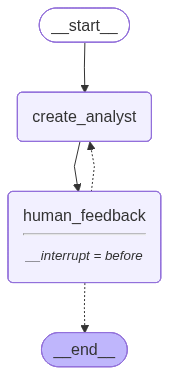

In [26]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [27]:
topic = "the benefits of adopting Langgraph as agent framework"
max_analysts = 4
thread = {"configurable":{"thread_id":1}}

In [28]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
              thread,
              stream_mode="values"):
    analysts = event.get("analysts",'')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Alice Thompson
Affiliation: Tech Solutions Inc.
Role: AI Infrastructure Engineer
Description: Focuses on the practical aspects of integrating Langgraph into existing systems, emphasizing scalability, cost-effectiveness, and ease of deployment. Concerned with the learning curve for engineers and the availability of robust monitoring and debugging tools.
--------------------------------------------------
Name: Bob Garcia
Affiliation: Innovation Lab
Role: AI Research Scientist
Description: Interested in Langgraph's potential to facilitate complex agent interactions and emergent behavior. Explores its use in novel AI applications, such as multi-agent reinforcement learning and decentralized decision-making. Motivated by pushing the boundaries of AI research.
--------------------------------------------------
Name: Charlie Lee
Affiliation: Global Corp
Role: AI Product Manager
Description: Evaluates Langgraph from a product perspective, focusing on its potential to improve existing AI 

In [29]:
state = graph.get_state(thread)

In [30]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Alice Thompson', role='AI Infrastructure Engineer', affiliation='Tech Solutions Inc.', description='Focuses on the practical aspects of integrating Langgraph into existing systems, emphasizing scalability, cost-effectiveness, and ease of deployment. Concerned with the learning curve for engineers and the availability of robust monitoring and debugging tools.'), Analyst(name='Bob Garcia', role='AI Research Scientist', affiliation='Innovation Lab', description="Interested in Langgraph's potential to facilitate complex agent interactions and emergent behavior. Explores its use in novel AI applications, such as multi-agent reinforcement learning and decentralized decision-making. Motivated by pushing the boundaries of AI research."), Analyst(name='Charlie Lee', role='AI Product Manager', affiliation='Global Corp', description='Evaluates Langgraph from a prod

In [31]:
graph.update_state(thread,{"human_analyst_feedback":"add something from the startup perspective and focus on "}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b2e9f-7783-6845-8002-42ca00b45691'}}

In [32]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
              thread,
              stream_mode="values"):
    analysts = event.get("analysts",'')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Alice Thompson
Affiliation: Tech Solutions Inc.
Role: AI Infrastructure Engineer
Description: Focuses on the practical aspects of integrating Langgraph into existing systems, emphasizing scalability, cost-effectiveness, and ease of deployment. Concerned with the learning curve for engineers and the availability of robust monitoring and debugging tools.
--------------------------------------------------
Name: Bob Garcia
Affiliation: Innovation Lab
Role: AI Research Scientist
Description: Interested in Langgraph's potential to facilitate complex agent interactions and emergent behavior. Explores its use in novel AI applications, such as multi-agent reinforcement learning and decentralized decision-making. Motivated by pushing the boundaries of AI research.
--------------------------------------------------
Name: Charlie Lee
Affiliation: Global Corp
Role: AI Product Manager
Description: Evaluates Langgraph from a product perspective, focusing on its potential to improve existing AI 

In [33]:
state = graph.get_state(thread)
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'add something from the startup perspective and focus on ', 'analysts': [Analyst(name='Ava Chen', role='Startup CTO', affiliation='Early-Stage Startup', description='Focuses on rapid prototyping and scalability. Concerned about the learning curve and integration costs of new technologies like Langgraph. Motivated by quick wins and demonstrable ROI.'), Analyst(name='Ben Carter', role='AI Research Scientist', affiliation='Academic Institution', description='Interested in the theoretical advantages of Langgraph, such as its ability to handle complex agent interactions and improve overall system robustness. Focuses on benchmarking Langgraph against other agent frameworks.'), Analyst(name='Priya Sharma', role='Enterprise Architect', affiliation='Large Corporation', description='Concerned with the maintainability, security, and governance aspects of Langgraph. 

In [34]:
state.next

('human_feedback',)

In [35]:
further_feedback = "None"
graph.update_state(thread,{"human_analyst_feedback":further_feedback}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b2e9f-92a2-6941-8006-36287ce31127'}}

In [36]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [37]:
final_state.next

('create_analyst',)

## Second Workflow

In [38]:
import os
from dotenv import load_dotenv
load_dotenv()
tavily_api_key = os.getenv("TAVILY_API_KEY")


In [39]:
from langchain_community.tools import TavilySearchResults
tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)

tavily_search.invoke("LLM")


C:\Users\bsmun\AppData\Local\Temp\ipykernel_19736\3464101177.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)


[{'title': 'Large language model - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/Large_language_model',
  'content': 'A large language model (LLM) is a language model trained with self-supervised machine learning on a vast amount of text, designed for natural language processing tasks, especially language generation. The largest and most capable LLMs are generative pre-trained transformers (GPTs) and provide the core capabilities of chatbots such as ChatGPT, Gemini "Gemini (chatbot)") and Claude "Claude (language model)"). LLMs can be fine-tuned "Fine-tuning (deep learning)") for specific tasks or guided by [...] An LLM is a type of foundation model (large X model) trained on language. LLMs can be trained in different ways. In particular, GPT models are first pretrained to predict the next word on a large amount of data, before being fine-tuned.[citation needed]\n\n### Cost\n\n[edit] [...] They consist of billions to trillions of parameters and operate as general-purpose sequence

In [40]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="langgraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


In [41]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int
    context: Annotated[list, operator.add]
    analyst: Analyst
    interview: str
    sections: list

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrival")

In [42]:
def _state_map(state):
    """Return a dict-like mapping for the provided state.
    Accepts dicts, Pydantic v2 model instances (model_dump), Pydantic v1 (dict),
    or falls back to __dict__.
    """
    if isinstance(state, dict):
        return state
    # Pydantic v2
    if hasattr(state, "model_dump"):
        try:
            return state.model_dump()
        except Exception:
            pass
    # Pydantic v1
    if hasattr(state, "dict"):
        try:
            return state.dict()
        except Exception:
            pass
    # fallback: try __dict__ or return original
    return getattr(state, "__dict__", state)


In [43]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [44]:
print(analyst.persona)

Name: David Lee
Role: AI Product Manager
Affiliation: Technology Company
Description: Focuses on the practical applications and user experience of Langgraph-powered agents. Interested in how Langgraph can be used to build more intuitive and effective AI products.



In [45]:
def generation_question(state:InterviewState):
    m = _state_map(state)
    analyst = m.get("analyst")
    messages = m.get("messages", [])

    system_messages = question_instructions.format(goals = analyst.persona if analyst is not None else "")
    question = llm.invoke([SystemMessage(content=system_messages)]+messages)

    return {"messages":[question]}


In [46]:
state = {"max_num_turns":2, "context":[],"analyst":analyst, "interview":"", "sections":[], "messages":[HumanMessage(content="hi do the proper research according to the expertises")]}

In [47]:
result = generation_question(state)
print(result["messages"][0].content)

Okay, here we go.

Hi David, my name is Anya Sharma, and I'm an analyst looking into the practical applications of Langgraph, particularly from a product perspective. I understand you're an AI Product Manager with experience in this area.

To kick things off, I'm curious: what's the most *surprising* thing you've learned about using Langgraph to build agents, compared to more traditional agent frameworks? I'm not looking for general benefits, but something that genuinely made you say, "Wow, I didn't expect that."


In [48]:
print(result) 

{'messages': [AIMessage(content='Okay, here we go.\n\nHi David, my name is Anya Sharma, and I\'m an analyst looking into the practical applications of Langgraph, particularly from a product perspective. I understand you\'re an AI Product Manager with experience in this area.\n\nTo kick things off, I\'m curious: what\'s the most *surprising* thing you\'ve learned about using Langgraph to build agents, compared to more traditional agent frameworks? I\'m not looking for general benefits, but something that genuinely made you say, "Wow, I didn\'t expect that."', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--86163537-16d3-417a-bd96-13bdf4d7033f-0', usage_metadata={'input_tokens': 218, 'output_tokens': 120, 'total_tokens': 338, 'input_token_details': {'cache_read': 0}})]}


In [49]:
from langchain_core.messages import get_buffer_string
search_instruction = SystemMessage(
    content="""
You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query
"""
)

In [50]:
def search_web(state:InterviewState):
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instruction]+state["messages"])

    search_docs = tavily_search.invoke(search_query.search_query)
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]}



In [51]:
state = {"max_num_turns":2, "context":[],"analyst":analyst, "interview":"", "sections":[], 'messages': [AIMessage(content='Okay, here we go.\n\nHello David, my name is Anya Sharma, and I\'m an analyst focusing on the practical applications of AI. I\'m particularly interested in Langgraph and its potential to move beyond theoretical applications and solve real-world problems.\n\nGiven your experience as an AI Product Manager, I\'m hoping you can provide some specific insights into how Langgraph is being used, or *could* be used, to create tangible value.\n\nTo start, what\'s the most *interesting* or *surprising* application of Langgraph you\'ve come across, something that really made you think, "Wow, this is a game-changer"? I\'m not necessarily looking for the *most* impactful, but the one that sparked the most creative thinking for you.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--34bae306-f359-454f-a007-d6bb515ef6ce-0', usage_metadata={'input_tokens': 233, 'output_tokens': 163, 'total_tokens': 396, 'input_token_details': {'cache_read': 0}})]}

In [52]:
result = search_web(state)

In [53]:
result['context'][0]

'<Document href="https://www.scalablepath.com/machine-learning/langgraph"/>\nThat’s where LangGraph comes in. LangGraph is a framework for building stateful, multi-agent applications powered by large language models. It helps developers move beyond the limitations of single-turn prompts by orchestrating agent interactions, managing memory, and defining workflows through a graph-based architecture. In this post, we’ll walk through where AI agents stand today, what makes LangGraph different, and how teams are already using it to build more reliable, production-ready AI [...] Table Of Contents\n\n LangChain and the Rise of Agentic AI Architectures\n Introducing LangGraph\n What is LangGraph and How Does it Work?\n LangGraph Studio: A Companion Visual IDE for Agent Workflows\n Common Agentic Workflow Patterns — Powered by LangGraph\n Multi-Agent Workflows with LangGraph\n Why Businesses Should Care About Agentic Workflows\n Practical Use Cases\n How Can Your Company Integrate LangGraph?\n 

In [54]:
print(result)

{'context': ['<Document href="https://www.scalablepath.com/machine-learning/langgraph"/>\nThat’s where LangGraph comes in. LangGraph is a framework for building stateful, multi-agent applications powered by large language models. It helps developers move beyond the limitations of single-turn prompts by orchestrating agent interactions, managing memory, and defining workflows through a graph-based architecture. In this post, we’ll walk through where AI agents stand today, what makes LangGraph different, and how teams are already using it to build more reliable, production-ready AI [...] Table Of Contents\n\n LangChain and the Rise of Agentic AI Architectures\n Introducing LangGraph\n What is LangGraph and How Does it Work?\n LangGraph Studio: A Companion Visual IDE for Agent Workflows\n Common Agentic Workflow Patterns — Powered by LangGraph\n Multi-Agent Workflows with LangGraph\n Why Businesses Should Care About Agentic Workflows\n Practical Use Cases\n How Can Your Company Integrate 

In [55]:
from langchain_community.utilities import WikipediaAPIWrapper
wiki = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=4000)
docs = wiki.run("artificial intelligence")
print(docs)

Page: Artificial intelligence
Summary: Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.
High-profile applications of AI include advanced web search engines (e.g., Google Search); recommendation systems (used by YouTube, Amazon, and Netflix); virtual assistants (e.g., Google Assistant, Siri, and Alexa); autonomous vehicles (e.g., Waymo); generative and creative tools (e.g., language models and AI art); and superhuman play and analysis in strategy games (e.g., chess and Go). However, many AI applications are not perceived as AI: "A lot of cutting edge AI has filtered into general 

In [56]:
def search_wikipedia(state:InterviewState):
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instruction]+state["messages"])

    print("*******************************")
    print(search_query)

    search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs=2).load()
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context":[formatted_search_docs]}

In [57]:
search_wikipedia(state)

*******************************
search_query='Langgraph applications and use cases'


{'context': ['<Document source="https://en.wikipedia.org/wiki/LangChain" page=""/>\nLangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain\'s use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.\n\n\n== History ==\nLangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, LangChain had incorporated and the new startup raised over $20 million in funding at a valuation of at least $200 million from venture firm Sequoia Capital, a week after announcing a $10 million seed investment from Benchmark.\nIn the third quarter of 2023, the LangChain Expression Language (LCEL) was introduced, which provides a declarative way to define chains of actions.\nIn October 2023 LangChain introdu

In [58]:
result = search_web(state)

In [59]:
print(result)

{'context': ['<Document href="https://www.scalablepath.com/machine-learning/langgraph"/>\nThat’s where LangGraph comes in. LangGraph is a framework for building stateful, multi-agent applications powered by large language models. It helps developers move beyond the limitations of single-turn prompts by orchestrating agent interactions, managing memory, and defining workflows through a graph-based architecture. In this post, we’ll walk through where AI agents stand today, what makes LangGraph different, and how teams are already using it to build more reliable, production-ready AI [...] Table Of Contents\n\n LangChain and the Rise of Agentic AI Architectures\n Introducing LangGraph\n What is LangGraph and How Does it Work?\n LangGraph Studio: A Companion Visual IDE for Agent Workflows\n Common Agentic Workflow Patterns — Powered by LangGraph\n Multi-Agent Workflows with LangGraph\n Why Businesses Should Care About Agentic Workflows\n Practical Use Cases\n How Can Your Company Integrate 

In [60]:
answer_instruction="""You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [61]:
def generate_answer(state:InterviewState):
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    system_message = answer_instruction.format(goals=analyst.persona,context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    answer.name = "expert"

    return {"messages":[answer]}

In [62]:
def route_messages(state:InterviewState, name:str = "expert"):
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)
    num_responses = len([m for m in messages if isinstance(m,AIMessage) and m.name==name])

    if num_responses >= max_num_turns:
        return 'save_interview'
    
    last_question = messages[-2]
    if "Thank you so much for your help" in last_question:
        return 'save_interview'
    
    return "ask_question"




In [63]:
def save_interview(state:InterviewState):
    messages = state["messages"]

    interview = get_buffer_string(messages)

    return {"interview":interview}



In [64]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [65]:
def write_section(state:InterviewState):
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")])

    return {"sections":[section.content]}

In [66]:
interview_builder = StateGraph(InterviewState)

In [67]:
interview_builder.add_node("ask_question", generation_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("generate_answer", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

In [68]:
interview_builder.add_edge(START,"ask_question")
interview_builder.add_edge("ask_question","search_web")
interview_builder.add_edge("ask_question","search_wikipedia")
interview_builder.add_edge("search_web", "generate_answer")
interview_builder.add_edge("search_wikipedia","generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                           route_messages,
                           ["ask_question","save_interview"])
interview_builder.add_edge("save_interview","write_section")
interview_builder.add_edge("write_section",END)

In [69]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interview")

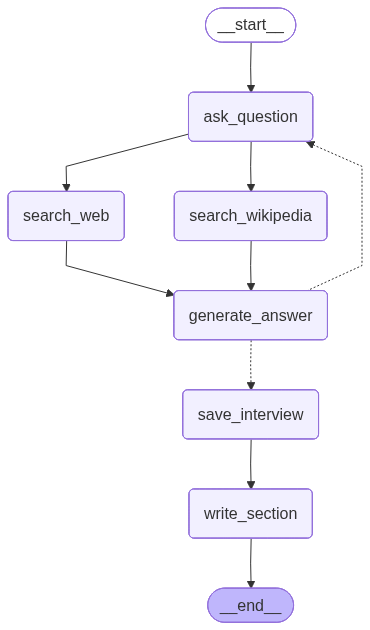

In [70]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [71]:
analyst.persona

'Name: David Lee\nRole: AI Product Manager\nAffiliation: Technology Company\nDescription: Focuses on the practical applications and user experience of Langgraph-powered agents. Interested in how Langgraph can be used to build more intuitive and effective AI products.\n'

In [72]:
from IPython.display import Markdown
messages = [HumanMessage("So you said you are writing an article on MCP")]

thread = {"configurable": {"thread_id": "1"}}

In [73]:
interview = interview_graph.invoke({
    "analyst":analyst, 
    "messages":messages,
    "max_num_turns":2, 
    "section": [],  
    "interview": "" },thread)

*******************************
search_query='Langgraph benefits for AI agent user experience'
*******************************
search_query='Langgraph state machine for LLMs'


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15
Please retry in 13.875855706s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 15
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seco

In [74]:
print('section (singular):', interview.get('section'))

section (singular): None


In [75]:
type(interview)

dict

In [76]:
for i,j in interview.items():
    print(i, ":", j)

messages : [HumanMessage(content='So you said you are writing an article on MCP', additional_kwargs={}, response_metadata={}, id='6c9dcdd0-4939-4480-845b-747327621ea4'), AIMessage(content="Hi David, I'm Alex Chen, a product analyst exploring the potential of Langgraph for a piece I'm writing. I understand you're working on AI products powered by Langgraph. I'm particularly interested in understanding how Langgraph helps create more intuitive and effective user experiences.\n\nTo start, what's the biggest challenge you've faced when trying to build user-friendly AI agents, and how has Langgraph helped you overcome it?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--26e979c2-7123-4dc0-aff4-a2b7a095cb62-0', usage_metadata={'input_tokens': 217, 'output_tokens': 94, 'total_tokens': 311, 'input_token_details': {'cache_read': 0}}), AIMessage(conte

In [77]:
Markdown(interview['sections'][0])

## LangGraph: Revolutionizing AI Agent Development for Enhanced User Experiences

### Summary
LangGraph, a library built on top of LangChain, is designed to create cyclic graphs for LLM-based AI agents, enabling more flexible and nuanced agent behaviors than linear models [1]. It allows developers to move beyond single-turn prompts by orchestrating agent interactions, managing memory, and defining workflows through a graph-based architecture [2]. This framework streamlines the creation of sophisticated AI applications by efficiently defining, coordinating, and executing multiple LLM agents (or chains) in a structured, cyclical manner [1].

LangGraph facilitates cyclic LLM call execution with state persistence, which is essential for agentic behavior [1]. Inspired by Pregel and Apache Beam, and modeled after the NetworkX library, LangGraph offers an advanced approach to agent runtimes [1]. Unlike predecessors that rely on basic loops, LangGraph supports intricate systems of nodes and edges, allowing developers to create more complex decision-making processes and action sequences [1].

Key features and benefits of LangGraph include:

1.  **Stateful, Multi-Agent Applications:** LangGraph helps developers build applications that manage memory and orchestrate agent interactions through a graph-based architecture [2].
2.  **Granular Control:** LangGraph enables granular control over the agent's thought process, empowering data-driven decisions to meet diverse user needs [3].
3.  **Scalability and Flexibility:** The framework is designed to build robust, scalable, and flexible multi-agent systems, making the development of intelligent AI workflows smoother and more efficient [1].
4.  **Tool Integration:** LangGraph allows agents to interact with a wide range of external systems, from simple APIs to complex, stateful services [4].
5.  **Production-Ready Features:** LangGraph, combined with LangSmith, provides an out-of-the-box solution to iterate quickly, debug immediately, and scale effortlessly, setting the foundation for building and scaling AI workloads [3].

### Sources
[1] https://medium.com/pythoneers/building-ai-agent-systems-with-langgraph-9d85537a6326
[2] https://www.scalablepath.com/machine-learning/langgraph
[3] https://www.langchain.com/langgraph
[4] https://medium.com/@amolkavitkar/building-an-advanced-ai-agent-a-step-by-step-guide-to-integrating-mcp-servers-with-langgraph-ff5f1d9db6e6

## Third Workflow

In [78]:
from typing_extensions import TypedDict
from typing import List, Annotated
import operator

class ResearchGraphState:
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]
    sections: Annotated[list, operator.add]
    introduction: str
    content: str
    conclusion: str
    final_report: str



In [ ]:
from langgraph.constants import send


ImportError: cannot import name 'send' from 'langgraph.utils' (d:\Sunny_savitha\auto_rec\automated-research-report-generation\.venv\Lib\site-packages\langgraph\utils\__init__.py)

In [ ]:
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analyst", create_analyst)
builder.add_node("human_feedback",human_feedback)
builder.add_node("conduct_interview",interview_builder.compile())
builder.add_node("write_report", write_report)
